<a href="https://colab.research.google.com/github/kathrein/code_sample/blob/main/Aravec_model_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
import loading
import process_aravec
from gensim.models import Word2Vec
import os
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.layers import Input,Embedding, Conv1D,MaxPooling1D,GlobalMaxPooling1D, Dense,Dropout,LSTM,Flatten,GRU,Bidirectional,GlobalAveragePooling1D
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns             
from keras import regularizers
from keras.models import Model


/Users/xabuka/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/xabuka/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/xabuka/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/xabuka/opt/anaconda3/lib/python3.7/site-packages/tensorflow/

In [ ]:
max_features = 25000
max_len = 130#77

# Convolution
kernel_size = 5
filters = 64
pool_size = 2

# LSTM
lstm_output_size = 70
#keras model
epochs = 100
batch_size=50

#data directory
#data_dir = '../data/SplitedPalSent'
#data_dir = '../data/ASTD'
import pandas as pd
#df = pd.read_csv("../data/ASTD/astd.csv", delimiter=';', header=None, names=['sentence','label_tag', 'label'],encoding = "utf-8")
#df = pd.read_csv("../data/ASTD/40k.csv", delimiter=';', header=None, names=['sentence', 'label'],encoding = "utf-8")
#df = pd.read_csv("../data/ASTD/ATSAD.csv", delimiter=';', header=None, names=['label_tag','sentence', 'label'],encoding = "utf-8")
#df = pd.read_csv("../data/ASTD/Madar6.csv", delimiter=';', header=None, names=['sentence', 'label'])
df = pd.read_csv("../data/ASTD/shami.csv", delimiter=';', header=None, names=['sentence', 'label'],encoding = "utf-8")
#df = pd.read_csv("../data/ASTD/padic.csv", delimiter=';', header=None, names=['sentence', 'label'],encoding = "utf-8")
df = df.sample(frac=1).reset_index(drop=True)
df.label = pd.factorize(df.label)[0]
df.sample(10)
#data_dir = '../data/labr5/clean'
#data_dir = '../data/labr3'
#data_dir = '../data/labr2'
#data_dir = '../data/Shami'
#train_dir = '..⁩/..⁩/MADAR_ArbDialectID/Task1⁩/⁨data/⁨D6_26⁩/6dialects⁩/splited_train⁩/⁨BEI'
#test_dir = '..⁩/..⁩/MADAR_ArbDialectID/Task1⁩/⁨data/⁨D6_26⁩/6dialects⁩/splited_dev⁩/⁨BEI'

,sentence,label
31323,مرت عمي ماقالت لالك شو بصير,2
35461,يارا ما تزعل مني انا ما بعرف شو صار,2
30107,بعدين نظفي بيتك وحطي العحينه تبعت الصراصير با...,1
58913,ياسمين اوك جيبيلي عصير على غرفتي,2
11218,رجعت مكرهه لغرفتي وانا مو مقتنعه بالذات انو ح...,2
33988,ابراهيم كنعان لازم يكون في تمييز بين النائب و...,3
41044,الاوضاع ببلدنا عم تصير كل يوم اصعب,3
7358,لك يانذل اتركها شو بدك فيها,2
18859,غاده ايه اريح هي تضل بعيده عني وكتر خيرها شو ...,2
10624,وليد ضرب ايدو بالحيط لك انتي كيف ما فهمتي,2


In [ ]:
def load_train(text,label, maxlen,max_words):
#train_directory
    
    #train_dir = os.path.join(imdb_dir, 'train')
    labels = label
    texts = []
    
    for t in text:
        texts.append(str(t))
    #print('length'+str(len(texts)))

    tokenizer = Tokenizer(num_words=max_words,split=' ')
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    
    data = pad_sequences(sequences, maxlen=maxlen,padding='post')
    labels = np.asarray(labels)
    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', labels.shape)
    # Split the data into a training set and a validation set
    # But first, shuffle the data, since we started from data
    # where sample are ordered (all negative first, then all positive).
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    print("Data = {0:d}".format(len(data)))
    data = data[indices]
    labels = labels[indices]
    
    training_samples= len(data)
    x_train = data[:training_samples]
    y_train = labels[:training_samples]
    #if not binary:
    # to use for Dialect identifaction and comment it when SA
    y_train = to_categorical(y_train, num_classes=4)
    
        
    #else:
        #x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
        #return x_train, x_test, y_train, y_test
        #print(type(x_train))
        #print(type(y_train))
    return x_train, y_train, word_index
    
    
def load_test(text,label, maxlen,max_words):

    labels = label
    texts = []
    
    for t in text:
        texts.append(str(t))
    
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    x_test = pad_sequences(sequences, maxlen=maxlen,padding='post')
    
    #print(labels)
    y_test = np.asarray(labels)
    
    
    #print(y_test)
    return x_test, y_test

 

In [ ]:
#import loading
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

#input_test, y_test = loading.load_test(data_dir,max_len,max_features,binary = True )


all_sentences = df.sentence.values
all_labels = df.label.values
print('total # of doc: ')
print(len(all_sentences))
#if we have two seperated files for train and test, pleease commit the following code
# and remove word all_ from the previous two lines.
from sklearn.model_selection import train_test_split

# as we have separate test set , then no need to split here
train_df, test_df = train_test_split(df, test_size=0.1)
train_sentences = train_df.sentence.values
train_labels = train_df.label.values
test_sentences = test_df.sentence.values
test_labels = test_df.label.values
#df.sample(100)

input_train, y_train, word_index  = load_train(train_sentences,train_labels, max_len,max_features)
print('train : ')
print(len(input_train))
print(len(y_train))

input_test, y_test = load_test(test_sentences,test_labels,max_len,max_features)



print('test : ')
print(len(input_test))
print(len(y_test))
#type(train_sentences)


#print(input_test[1])




total # of doc: 
66251
Found 95117 unique tokens.
Shape of data tensor: (59625, 130)
Shape of label tensor: (59625,)
Data = 59625
train : 
59625
59625
test : 
6626
6626


In [ ]:
def embedding_matrix(word_index,max_len,max_features):
    ara_dir = '../data/tweet_cbow_300/'
    word_index = word_index#loading.word_index(data_dir,max_len,max_features,True)
    t_model = Word2Vec.load(os.path.join(ara_dir,'tweets_cbow_300'))

    print('Found %s word vectors.' % len(t_model.wv.index2word))# how many words in aravec this model
    embeddings_index = t_model.wv

    embedding_dim = embeddings_index.vector_size #300
    embedding_matrix = np.zeros((max_features, embedding_dim))

    for word, i in word_index.items():
        word = process_aravec.clean_str(word).replace(" ", "_")
        check = False
        if word in embeddings_index:
            w = word
            check = True
        elif word[1:] in embeddings_index:
            w= word[1:]
            check = True
        elif word[:-2] in embeddings_index:
            w= word[:-2]
            check = True
        if check:
            embedding_vector = embeddings_index[w]
            if i < max_features:
                if embedding_vector is not None:
                    # Words not found in embedding index will be all-zeros.
                    embedding_matrix[i] = embedding_vector
                    #print(len(embedding_vector))
       
        
    return  embedding_matrix  
embedding_matrix = embedding_matrix(word_index,max_len,max_features)
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / max_features)
#for dialetct PAl it only covers 35% of the vocabulary
# for MSA it covers 98%
#ASTD . 90%
#shami 67%, 78

Found 331679 word vectors.
0.98072


In [ ]:
#building model CNN + LSTM
#tried on ASTD 
print(embedding_matrix.shape)
model = Sequential()
model.add(Embedding(max_features, 300,weights=[embedding_matrix], trainable=True, input_length=max_len))
model.add(LSTM(70,dropout=0.5, recurrent_dropout=0.5))#,return_sequences=True)))
#model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(30))
#model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics =['acc'])
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())



(25000, 300)
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 130, 300)          7500000   
_________________________________________________________________
lstm_15 (LSTM)               (None, 70)                103880    
_________________________________________________________________
dropout_15 (Dropout)         (None, 70)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 30)                2130      
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 124       
Total params: 7,606,134
Trainable params: 7,606,134
Non-trainable params: 0
_________________________________________________________________
None


model = Sequential()
model.add(Embedding(max_features, 100,weights=[embedding_matrix], trainable=True, input_length=max_len))
#model.add(Flatten())
#model.add(Conv1D(100, 10, activation='relu'))
model.add(Conv1D(100, 10, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(160, 10, activation='relu'))
#model.add(Conv1D(160, 10, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics =['acc'])
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())


#LSTM  EXP 16
model=Sequential()
model.add(Embedding(max_features, 300,weights=[embedding_matrix], trainable=True, input_length=max_len)) 
model.add(Bidirectional(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True)))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()


#CNN_19,2


def create_convnet(max_features, vectore_d):
    input_shape = Input(shape=(max_features, vectore_d))
    conv = []
    for filters in [32,64,128]:
        for k_size in [2,3,4,5,6]:
            tower = Conv1D(filters, k_size, activation='relu')(input_shape)
            tower = GlobalMaxPooling1D()(tower)
            conv.append(tower)
    
    merged = layers.concatenate([tower for tower in conv], axis=1)
   
    
    out = Dense(10,activation='relu')(merged)
    #out = Dropout(0.3)(out)
    #out = Dense(30)(out)
    out = Dense(1, activation='sigmoid')(out)

    model = Model(input_shape, out)
    #print(model.summary())
    from keras.utils.vis_utils import plot_model
    #plot_model(model, to_file=filepath+'.png', show_shapes=True, show_layer_names=True)
    return model


input_shape =(max_features, )
model = Sequential()
model.add(Embedding(max_features, 300,weights=[embedding_matrix], trainable=True, input_length=max_len)) 
model.add(Bidirectional(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences= True)))
#model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences= True)))
#model.add(Dropout(0.5))
model.add(create_convnet(max_len, 128))



#model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics =['acc'])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())


#EXP LSTM 9+17
model=Sequential()
model.add(Embedding(max_features, 300,weights=[embedding_matrix], trainable=True, input_length=max_len)) 
model.add(Bidirectional(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True)))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())


#building model CNN + LSTM kagg
model = Sequential()
model.add(Embedding(max_features, 300,weights=[embedding_matrix], trainable=True, input_length=max_len)) 
model.add(Dropout(0.2))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Dropout(0.2))
model.add(Conv1D(32, 3, padding='valid', activation='relu', strides=1))
#model.add(Flatten())
model.add(LSTM(lstm_output_size, dropout = 0.3, recurrent_dropout=0.3))
model.add(Dense(3,activation='sigmoid'))
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics =['acc'])
print(model.summary())   
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='weights/kaggle.png', show_shapes=True, show_layer_names=True)
    

In [ ]:
#filepath="weights/weights.best.exp_16.hdf5"

#model.load_weights(filepath)
filepath="weights/weights.BERT_shami.hdf5"

#saved_model = filepath
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
callbacks_list = [checkpoint,early_stopping]
history = model.fit(input_train, y_train,
                    epochs=100,
                    batch_size=32,
                    #validation_data=(x_val, y_val),
                    validation_split= 0.2,
                    callbacks=callbacks_list)#[early_stopping])


model.save_weights(filepath)   

Train on 47700 samples, validate on 11925 samples
Epoch 1/100
47700/47700 [==============================] - 385s 8ms/step - loss: 1.1530 - acc: 0.5713 - val_loss: 1.1571 - val_acc: 0.5639

Epoch 00001: val_loss improved from inf to 1.15706, saving model to weights/weights.BERT_shami.hdf5
Epoch 2/100
47700/47700 [==============================] - 5795s 121ms/step - loss: 1.1481 - acc: 0.5718 - val_loss: 1.1593 - val_acc: 0.5638

Epoch 00002: val_loss did not improve from 1.15706
Epoch 3/100
47700/47700 [==============================] - 409s 9ms/step - loss: 1.1467 - acc: 0.5718 - val_loss: 1.1578 - val_acc: 0.5636

Epoch 00003: val_loss did not improve from 1.15706
Epoch 4/100
47700/47700 [==============================] - 513s 11ms/step - loss: 1.1464 - acc: 0.5718 - val_loss: 1.1576 - val_acc: 0.5639

Epoch 00004: val_loss did not improve from 1.15706
Epoch 5/100
47700/47700 [==============================] - 479s 10ms/step - loss: 1.1456 - acc: 0.5721 - val_loss: 1.1589 - val_acc: 

# 'Testing And Evalaution'
1- classification report

In [ ]:
def plot_show(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

y_test = to_categorical(y_test, num_classes=4)
    #plot_show(history)
#filepath="weights/weights.best.exp16.hdf5"
#print(len(input_test))
model.load_weights(filepath)
#y_test.argmax(axis=1), predicte.argmax(axis=1)
scores= model.evaluate(input_test, y_test,verbose=0)
predicte = model.predict(input_test, verbose = 2, batch_size = batch_size)
print("Accuracy: %.2f%%" % (scores[1]*100))



#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file=filepath+'.png', show_shapes=True, show_layer_names=True)

Accuracy: 56.84%


In [ ]:
#test and Evaluation
#model.load_weights(filepath)
#predicted = model.predict_proba(input_test, verbose = 2, batch_size = batch_size)
#for binary
#print(predicte)
print(metrics.classification_report(y_test, np.round(predicte)))
#for multi-class
#print(metrics.classification_report(y_test.argmax(axis=1), predicte.argmax(axis=1)))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       688
           1       0.00      0.00      0.00      1047
           2       0.57      1.00      0.72      3769
           3       0.00      0.00      0.00      1122

   micro avg       0.57      0.57      0.57      6626
   macro avg       0.14      0.25      0.18      6626
weighted avg       0.32      0.57      0.41      6626
 samples avg       0.57      0.57      0.57      6626



/Users/xabuka/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xabuka/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')
#y_test, np.round(predicte)
# For each input batch...
#mcc = matthews_corrcoef(y_test, np.round(predicte))

mcc = matthews_corrcoef(y_test.argmax(axis=1), predicte.argmax(axis=1))



print('MCC: %.3f' % mcc)


Calculating Matthews Corr. Coef. for each batch...
MCC: 0.004


0.17403548296254576
Accuracy: 17.40%
[[  0   0 610   0   0   0]
 [  0   0 594   0   0   0]
 [  0   0 618   0   0   0]
 [  0   0 585   0   0   0]
 [  0   0 593   0   0   0]
 [  0   0 551   0   0   0]]


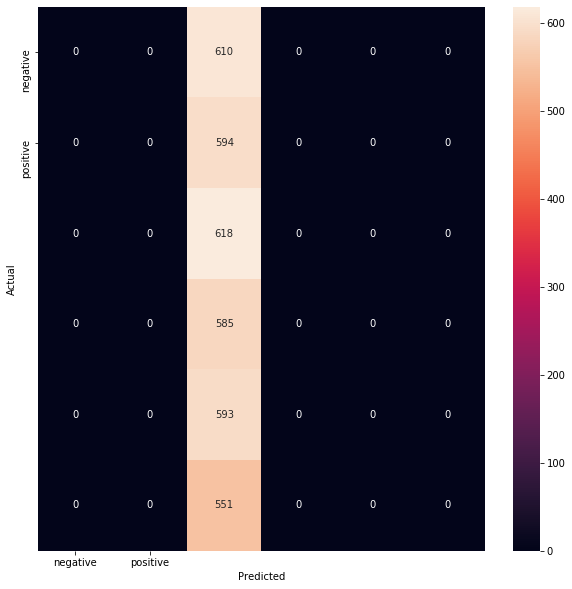

In [ ]:
#predicted = np.argmax(predicted, axis=1)
#scores= model.evaluate(input_test, y_test,verbose=0)
#for binary
#print(metrics.accuracy_score(y_test, np.round(predicte)))
#conf_mat = metrics.confusion_matrix(y_test, np.round(predicte))
#for multi
print(metrics.accuracy_score(y_test.argmax(axis=1), predicte.argmax(axis=1)))
conf_mat = metrics.confusion_matrix(y_test.argmax(axis=1), predicte.argmax(axis=1))

print("Accuracy: %.2f%%" % (scores[1]*100))
print(conf_mat)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
#for x,y,p in zip(input_test,y_test,predicte):
 #   print(x,y,p)
